In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('../data/facial/training.csv')
# 결측값 전부 지우고
df.dropna(inplace=True)
df.shape

(2140, 31)

### npstack
- 사용자가 지정한 차원(축으로) 배열을 연결
- axis = 0(defalut) 가장 앞쪽에 차원 생성
- 배열 두 개가 겹치게 됨(연결하고자 하는 배열들의 크기가 모두 같아야 함)
https://datascienceschool.net/view-notebook/17608f897087478bbeac096438c716f6/

In [55]:
from joblib import Parallel, delayed
# pip install joblib
def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype = np.uint8).reshape(96,96)

# 분산처리 작업
with Parallel(n_jobs=10, verbose=1, prefer ='threads') as ex:
    # Image column을 분리해서 list로 만들고 np.array로 바꿈
    x = ex(delayed(format_img)(e) for e in df.Image)
x = np.stack(x)[:,:,:,None]
print(x.shape)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    5.1s


(2140, 96, 96, 1)


[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:    6.1s finished


In [70]:
y = df.iloc[:, :-1].values
y.shape

(2140, 30)

### np.split
- 배열을 여러개의 하위배열로 분리
- np.split(, axis =0)이면 행으로 분리 vsplit으로 생각
- np.split(, axis =1)이면 열로 분리 hsplit으로 생각
- np.vsplit : 수직 축으로 배열 분할  
https://rfriend.tistory.com/359

In [95]:
np.stack(np.split(y[0], 15, axis = 0), axis = 0).T

(2, 15)

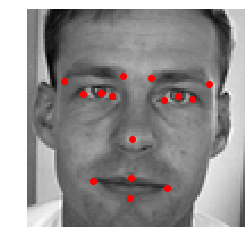

In [113]:
def show(x, y=None):
    plt.imshow(x[:,:,0], 'gray')
    if y is not None:
        # vertical stack 
        points = np.stack(np.split(y, 15, axis = 0),axis =0).T
        plt.plot(points[0], points[1],'o', color = 'red')
    plt.axis('off')
sample_idx = np.random.choice(len(x))
show(x[sample_idx], y[sample_idx])

### train_test_split
- 교차검증을 위한 다양한 명령 제공
https://datascienceschool.net/view-notebook/266d699d748847b3a3aa7b9805b846ae/

In [129]:

from sklearn.model_selection import train_test_split

# random_state는 난수시드
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2, random_state = 42)
print("x_train.shape :{}\nx_val.shape : {}".format(x_train.shape, x_val.shape))
print("y_train.shape :{}\ny_val.shape : {}".format(y_train.shape, y_val.shape))

x_train.shape :(1712, 96, 96, 1)
x_val.shape : (428, 96, 96, 1)
y_train.shape :(1712, 30)
y_val.shape : (428, 30)


In [137]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 데이터 정규화
x_train_norm = x_train[:,:,:,:]
x_val_norm = x_val[:,:,:,:]
x_train_norm = x_train_norm.reshape([-1, 96*96])
x_val_norm = x_val_norm.reshape([-1,96*96])
print("x_train_norm.shape : {}".format(x_train_norm.shape))
print("x_val_norm,.shape : {}".format(x_val_norm.shape))

x_train_norm = scaler.fit_transform(x_train_norm)
x_val_norm = scaler.fit_transform(x_val_norm)
print("x_train_norm.mean : {}".format(x_train_norm.mean()))
print("x_train_norm.std : {}".format(x_train_norm.std()))


x_train_norm.shape : (1712, 9216)
x_val_norm,.shape : (428, 9216)


C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


x_train_norm.mean : 0.4752519194072296
x_train_norm.std : 0.23269733883088617


In [138]:
x_train_norm = x_train_norm.reshape([-1,96,96,1])
x_val_norm = x_val_norm.reshape([-1,96,96,1])
print("x_train_norm.shape : {}".format(x_train_norm.shape))
print("x_val_norm,.shape : {}".format(x_val_norm.shape))


x_train_norm.shape : (1712, 96, 96, 1)
x_val_norm,.shape : (428, 96, 96, 1)


### keras model
- pip install Keras
- Sequential model
    - Conv2D
    - AvgPool2D
    - BatchNormalization
    - Flatten
    - Dropout
    - Dense
- model.compile
    - Adam, mse, 

### L1, L2정규화 / 배치정규화
- L1 정규화
    - 모델 가중치의 L1 norm(가중치의 각 요소 절대값의 합)에 대해 패널티를 부과
        - 불필요한 피처에 대응하는 가중치들을 0으로 만듬
        - 변수 선택효과
        - L2 정규화와 대조
- L2 정규화
    - 모델 가중치의 L2 norm(가중치 각 요소 제곱의 합)에 대해 패널티를 부과
        - 아주 큰 값이나 작은 값을 가지는 outlier 모델 가중치에 대해 0에 가깝지만 0은 아닌 값으로 만듬
        - L1 정규화와 대조

https://ratsgo.github.io/machine%20learning/2017/10/12/terms/ 

https://datascienceschool.net/view-notebook/f18248a467e94c6483783afc93d08af9/

In [142]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers

model = Sequential()
# 첫번째 layer는 input_shape을 줘야함
# filter, kernel size, activation, initializers(he_normal은 정규분포로 부터 표본)
model.add(Conv2D(16, (3,3), input_shape = (96,96,1), activation ='relu', kernel_initializer='he_normal' ))

